In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.datasets import cifar10


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
import matplotlib.pyplot as plt

In [4]:
def view_image_matplotlib(image, label=None):
    """Displays an image using matplotlib."""
    plt.imshow(image)
    if label is not None:
        plt.title(f"Label: {label}")
    plt.show()

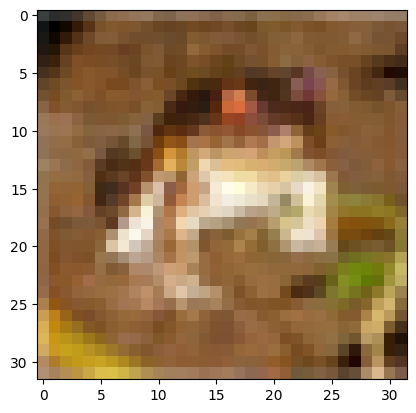

In [5]:
plt.imshow(x_train[0])

In [6]:
print(y_train[0])

[6]


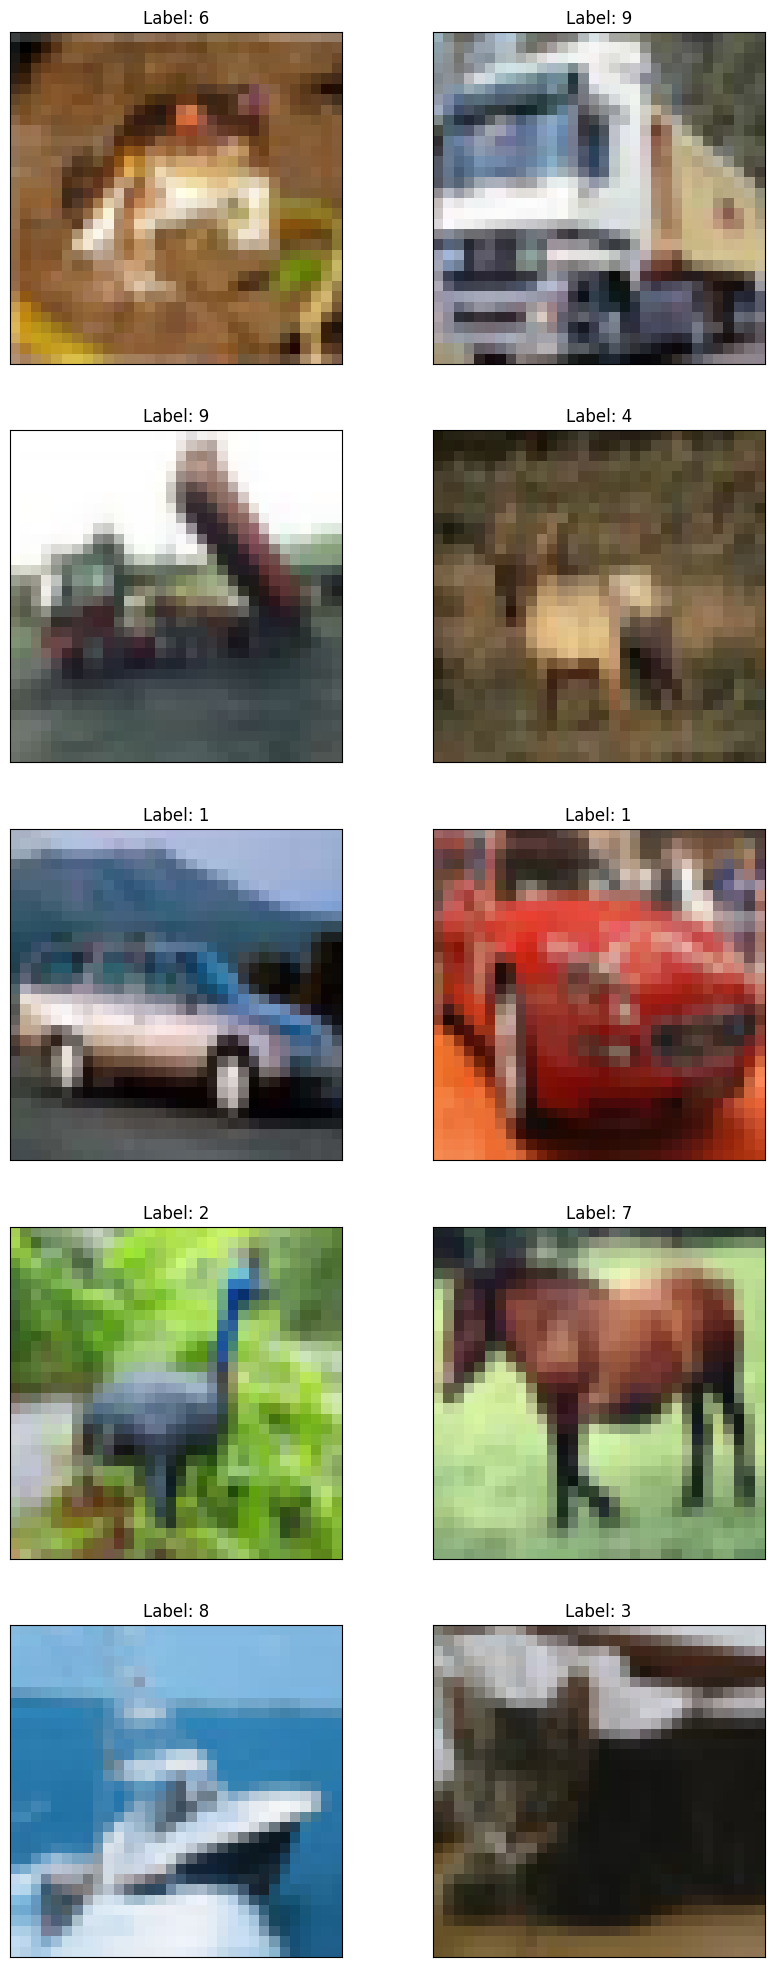

In [7]:
num_images = 10
num_rows = (num_images + 1) // 2
num_cols = 2

plt.figure(figsize=(10, num_rows * 5))

for index, i in enumerate(range(num_images)):
    plt.subplot(num_rows, num_cols, index + 1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.xticks([])
    plt.yticks([])

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Print label correspondences
for i, class_name in enumerate(class_names):
    print(f"{i} corresponds to {class_name}")

#Example of how to get label from y_train
print(f"The first image's label is {y_train[0][0]}, which corresponds to {class_names[y_train[0][0]]}")

0 corresponds to airplane
1 corresponds to automobile
2 corresponds to bird
3 corresponds to cat
4 corresponds to deer
5 corresponds to dog
6 corresponds to frog
7 corresponds to horse
8 corresponds to ship
9 corresponds to truck
The first image's label is 6, which corresponds to frog


In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [10]:
print(x_train[0].shape)

(32, 32, 3)


In [11]:
def resize_images(images, size=(32, 32)):
    resized_images = np.array([cv2.resize(img, size) for img in images])
    return resized_images

In [12]:

x_train_resized = resize_images(x_train, (32, 32))
x_test_resized = resize_images(x_test, (32, 32))


In [13]:
def convert_to_grayscale(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    return gray_images[..., np.newaxis]  # Add channel dimension

x_train_gray = convert_to_grayscale(x_train_resized)
x_test_gray = convert_to_grayscale(x_test_resized)

# Simulate Degradation

def add_gaussian_noise(images, mean=0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    return np.clip(images + noise, 0, 1)


def add_salt_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    noisy_images = images.copy()
    for img in noisy_images:
        num_salt = np.ceil(salt_prob * img.size)
        num_pepper = np.ceil(pepper_prob * img.size)

        salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
        pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]

        img[salt_coords[0], salt_coords[1], :] = 1
        img[pepper_coords[0], pepper_coords[1], :] = 0
    return noisy_images


def apply_gaussian_blur(images, kernel_size=(5, 5)):
    return np.array([cv2.GaussianBlur(img, kernel_size, 0) for img in images])


def apply_motion_blur(images, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    return np.array([cv2.filter2D(img, -1, kernel) for img in images])


def add_compression_artifacts(images, quality=50):
    compressed_images = []
    for img in images:
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encoded_img = cv2.imencode('.jpg', img * 255, encode_param)
        decoded_img = cv2.imdecode(encoded_img, 1) / 255.0
        compressed_images.append(decoded_img)
    return np.array(compressed_images)

# Apply Degradation Techniques
degraded_train = add_gaussian_noise(x_train_resized)
degraded_train = add_salt_pepper_noise(degraded_train)
degraded_train = apply_gaussian_blur(degraded_train)
degraded_train = apply_motion_blur(degraded_train)
degraded_train = add_compression_artifacts(degraded_train)

In [14]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam


In [15]:
input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [19]:
autoencoder = Model(input_img, out)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the Autoencoder
history = autoencoder.fit(degraded_train, x_train_resized,
                          epochs=100, batch_size=64,
                          validation_data=(x_test_resized, x_test_resized))


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0087 - val_loss: 0.0177
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0078 - val_loss: 0.0182
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0078 - val_loss: 0.0216
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0078 - val_loss: 0.0194
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0077 - val_loss: 0.0199
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0077 - val_loss: 0.0204
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0077 - val_loss: 0.0185
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0076 - val_loss: 0.0199
Epoch 9/100
621/782 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076

KeyboardInterrupt: 

In [17]:
restored_images = autoencoder.predict(x_test_resized)

# Evaluate Performance using PSNR
def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

psnr_values = [psnr(x_test_resized[i], restored_images[i]) for i in range(len(x_test_resized))]
print("Average PSNR:", np.mean(psnr_values))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Average PSNR: 17.764633


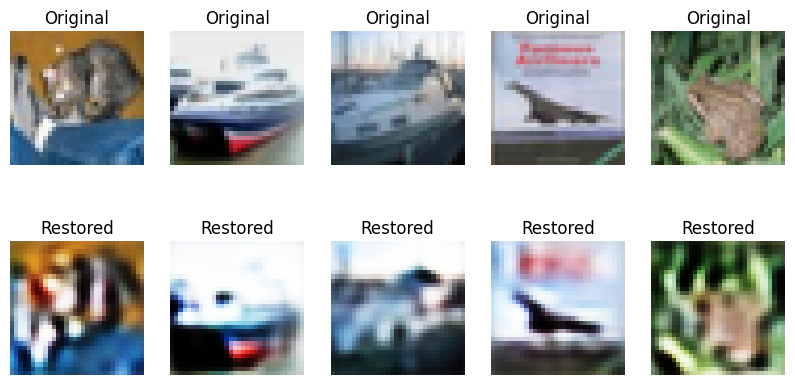

In [18]:
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(x_test_resized[i])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(2, n, i+1+n)
    plt.imshow(restored_images[i])
    plt.axis('off')
    plt.title("Restored")
plt.show()